In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Data prep, convert pixels to array from string
data = pd.read_csv("fer2013/fer2013.csv")
image_h, image_w = 48, 48

train = data.loc[data["Usage"] == "Training"]
validate = data.loc[data["Usage"] == "PublicTest"]
test = data.loc[data["Usage"] == "PrivateTest"]

train_X = [np.fromstring(image, dtype=int, sep=" ").reshape((
        image_h, image_w)) for image in train["pixels"]]
train_y = train["emotion"]
validate_X = [np.fromstring(image, dtype=int, sep=" ").reshape((
        image_h, image_w)) for image in validate["pixels"]]
validate_y = validate["emotion"]
test_X = [np.fromstring(image, dtype=int, sep=" ").reshape((
        image_h, image_w)) for image in test["pixels"]]
test_y = test["emotion"]

In [21]:
# map of encoded emotions
emotions = {
    "0": "Angry",
    "1": "Disgust",
    "2": "Fear",
    "3": "Happy",
    "4": "Sad",
    "5": "Surprise",
    "6": "Neutral"
}

Train Emotions
Number of records: 35887


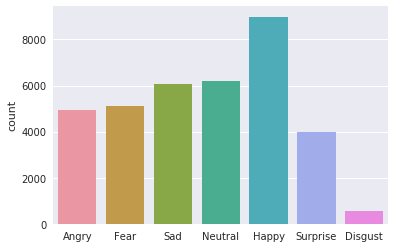

In [22]:
sns.set(style="darkgrid")
print("Train Emotions")
print(f"Number of records: {len(data)}")
#sns.countplot(x="emotion", data=data)
emotion_data = [emotions[str(x)] for x in data["emotion"]]
sns.countplot(x=emotion_data)

Train Emotions
Number of records: 28709


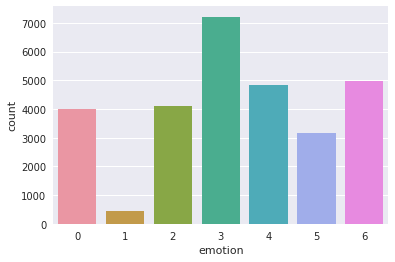

In [23]:
sns.set(style="darkgrid")
print("Train Emotions")
print(f"Number of records: {len(train_y)}")
sns.countplot(x="emotion", data=train)

Validate Emotions
Number of records: 3589


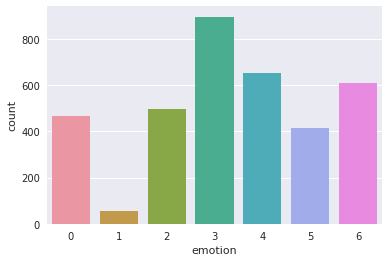

In [24]:
print("Validate Emotions")
print(f"Number of records: {len(validate_y)}")
sns.countplot(x="emotion", data=validate)

Test Emotions
Number of records: 3589


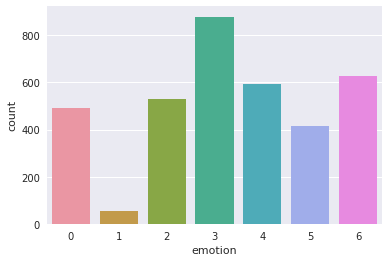

In [25]:
print("Test Emotions")
print(f"Number of records: {len(test_y)}")
sns.countplot(x="emotion", data=test)

(48, 48)
Surprise


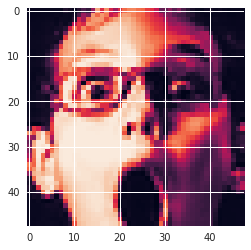

In [28]:
plt.imshow(train_X[1400])
print(train_X[1400].shape)
print(emotions[str(train_y[1400])])

In [9]:
# Prepare the images for the inception v3 model
import cv2
from keras.applications.inception_v3 import preprocess_input

#p_train_X = []
p_validate_X = []
p_test_X = []

#for i, im in enumerate(train_X):
#    im = im.astype(float)
#    im = cv2.resize(im, (299,299))
#    p_im = np.stack((im,)*3, axis=-1)
#    p_im = preprocess_input(p_im)
#    p_train_X.append(p_im)

for i, im in enumerate(validate_X):
    im = im.astype(float)
    im = cv2.resize(im, (299,299))
    p_im = np.stack((im,)*3, axis=-1)
    p_im = preprocess_input(p_im)
    p_validate_X.append(p_im)

for i, im in enumerate(test_X):
    im = im.astype(float)
    im = cv2.resize(im, (299,299))
    p_im = np.stack((im,)*3, axis=-1)
    p_im = preprocess_input(p_im)
    p_test_X.append(p_im)

In [10]:
#print(len(validate_X))
#p_train_X = np.asarray(p_train_X, dtype="f2")
#train_y = train_y[0:10000]
p_validate_X = np.asarray(p_validate_X, dtype="f2")
p_test_X = np.asarray(p_test_X, dtype="f2")

In [11]:
from keras.utils import np_utils

#train_y = np_utils.to_categorical(train_y, 7)
validate_y = np_utils.to_categorical(validate_y, 7)
test_y = np_utils.to_categorical(test_y, 7)

In [69]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.layers import Input

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- there are 7 classes
predictions = Dense(7, activation='softmax')(x)

# this is the model we will train
model = Model(input=base_model.input, output=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# train the model on the new data for a few epochs
model.fit(x=p_train_X, y=train_y, epochs=20, validation_data=(p_validate_X, validate_y))

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in model.layers[:172]:
   layer.trainable = False
for layer in model.layers[172:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit(x=p_train_X, y=train_y, epochs=5, validation_data=(p_validate_X, validate_y))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 28709 samples, validate on 3589 samples
Epoch 1/20
28709/28709 [==============================] - 1270s 44ms/step - loss: 1.8582 - val_loss: 1.6154
Epoch 2/20
28709/28709 [==============================] - 1267s 44ms/step - loss: 1.5700 - val_loss: 1.5908
Epoch 3/20
28709/28709 [==============================] - 1267s 44ms/step - loss: 1.5192 - val_loss: 1.5425
Epoch 4/20
28709/28709 [==============================] - 1267s 44ms/step - loss: 1.4932 - val_loss: 1.5516
Epoch 5/20
28709/28709 [==============================] - 1267s 44ms/step - loss: 1.4694 - val_loss: 1.6261
Epoch 6/20
28709/28709 [==============================] - 1267s 44ms/step - loss: 1.4516 - val_loss: 1.6794
Epoch 7/20
28709/28709 [==============================] - 1267s 44ms/step - loss: 1.4314 - val_loss: 1.5307
Epoch 8/20
28709/28709 [==============================] - 1267s 44ms/step - loss: 1.4155 - val_loss: 1.6180
Epoch 9/20
28709/28709 [==============================] - 1267s 44ms/step - loss: 1.399

Train on 28709 samples, validate on 3589 samples
Epoch 1/5
28709/28709 [==============================] - 2058s 72ms/step - loss: 1.1825 - val_loss: 1.1945
Epoch 2/5
28709/28709 [==============================] - 2053s 72ms/step - loss: 0.7676 - val_loss: 1.2312
Epoch 3/5
28709/28709 [==============================] - 2051s 71ms/step - loss: 0.4865 - val_loss: 1.3767
Epoch 4/5
28709/28709 [==============================] - 2052s 71ms/step - loss: 0.2900 - val_loss: 1.5455
Epoch 5/5
28709/28709 [==============================] - 2053s 72ms/step - loss: 0.1883 - val_loss: 1.6861


In [70]:
# serialize model to JSON
model_json = model.to_json()
with open("modelV3_longest.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("modelV3_longest.h5")
print("Saved model to disk")

Saved model to disk


In [1]:
from keras.models import model_from_json

# Run if loading the model rather than building
# load json and create model
json_file = open('modelV3_longer.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("modelV3_longer.h5")
print("Loaded model from disk")

Using TensorFlow backend.
/home/josh/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Loaded model from disk


In [12]:
test_preds = model.predict(p_test_X)

In [13]:
test_classes = [np.argmax(x) for x in test_preds]
test_y_real = [np.argmax(x) for x in test_y]

In [14]:
from sklearn.metrics import accuracy_score

print(accuracy_score(test_y_real, test_classes))

0.600167177487


In [15]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(test_y_real, test_classes))

[[184   5 103  26  72   7  94]
 [  9  28   6   5   4   1   2]
 [ 43   3 272  23  85  32  70]
 [ 21   0  23 708  37  23  67]
 [ 38   2 110  35 259   3 147]
 [ 13   0  57  29  12 283  22]
 [ 20   2  54  35  87   8 420]]


In [16]:
validate_preds = model.predict(p_validate_X)
validate_classes = [np.argmax(x) for x in validate_preds]
validate_y_real = [np.argmax(x) for x in validate_y]

from sklearn.metrics import accuracy_score

print(accuracy_score(validate_y_real, validate_classes))

0.599052660908


In [76]:
import pandas as pd

type(test_preds)

numpy.ndarray

In [17]:
test_preds_df = pd.DataFrame(test_preds)
test_preds_df.to_csv("test_preds_longer.csv")
validate_preds_df = pd.DataFrame(validate_preds)
validate_preds_df.to_csv("validate_preds_longer.csv")
test_actual_preds = pd.DataFrame(test_y)
validate_actual_preds = pd.DataFrame(validate_y)
test_actual_preds.to_csv("test_actual_y.csv")
validate_actual_preds.to_csv("validate_actual_y.csv")

In [19]:
print(test_preds[1])
print(test_y[1])

[  2.17508338e-02   1.75246430e-04   2.21623015e-02   3.02639906e-04
   9.34205770e-01   1.93930008e-02   2.01014848e-03]
[ 0.  0.  0.  0.  0.  1.  0.]


In [30]:
print(p_test_X[0].shape)

(299, 299, 3)
